In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from snsphd import viz
import math
import orjson
Colors, pallet = viz.phd_style(jupyterStyle = True, grid = True, axese_width=0.5, text = 6, svg_mode=True)

from enum import Enum
from dataclasses import dataclass, fields, field, _MISSING_TYPE 

from load_schema import Decode, Result, Event

import matplotlib as mpl
import os

# set the DPI for all figures
mpl.rcParams['figure.dpi'] = 100

from snsphd.layout import bisect

from numba import njit
from snsphd.viz import save_bokeh_dark_json
from snsphd.layout import bisect

from pydantic import BaseModel

In [2]:
db_values = np.arange(16,50, 2).tolist()
print(db_values)

# need type hints for intellisense to work
def decode_from_folder(folder_path: str, db_values: list[int]) -> list[Decode]:
    decodes = []
    for db in db_values:
        filename = f"decode_20GHz{db}.0.json"
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as f:
            data = orjson.loads(f.read())
            decode = Decode(**data)
            decodes.append(decode)
    return decodes

decodes = decode_from_folder("../inter", db_values)

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


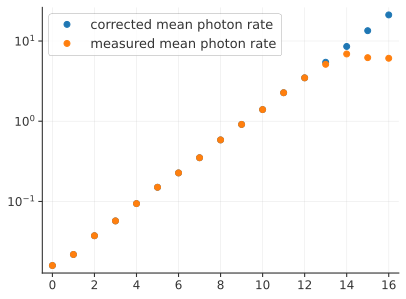

In [3]:
def calculate_mfr(struct: list[Decode]) -> list[float]:
    mfrs = []
    for d in range(len(struct)):
        missing = 0
        found = 0
        for res in struct[d].results[0]:
            result: Result = res.result
            if result == Result.MISSING:
                missing += 1
            if (result == Result.CORRECT) or (result == Result.INCORRECT):
                found += 1
        total = missing + found

        ratio_of_vacuum = missing/total
        mfr = -np.log(ratio_of_vacuum)
        mfrs.append(mfr)

    return mfrs


def calculate_corrected_mfr(struct: list[Decode]) -> list[float]:

    mfr = calculate_mfr(decodes)

    mfr = np.flip(mfr)
    ln_mfr = np.log(mfr)
    x = np.arange(len(ln_mfr))
    slope, intercept = np.polyfit(x[:-3], ln_mfr[:-3], 1)
    ln_mfr_ext = slope*x + intercept

    ln_mfr_corrected = ln_mfr.copy()
    ln_mfr_corrected[-4:] = ln_mfr_ext[-4:]
    mfr_corrected = np.exp(ln_mfr_corrected)

    plt.plot(x, mfr_corrected, 'o', label="corrected mean photon rate")
    plt.plot(x, mfr, 'o', label="measured mean photon rate")
    plt.yscale('log')
    plt.legend()

    # put the order back to what it was
    mfr = np.flip(mfr)
    mfr_corrected = np.flip(mfr_corrected)
    return mfr_corrected

mfr_corrected = calculate_corrected_mfr(decodes)

In [4]:
dbs = np.arange(16, 50, 2).tolist()

correction_vectors = []
for db in dbs:
    with open(f"../inter/offset_correction_{db}.json", "r") as f:
        data = json.loads(f.read())
        # print(data["correction_vector"])   
    correction_vectors.append(data["correction_vector"])

# print(correction_vectors)

In [83]:
import concurrent.futures
from worker import MultiprocessLoaderCorrector, pnr_caller, CallerResults
from multiprocessing import Pool

from worker import DecodingResults

from util import StaticSimulation
import copy
from util import PhotonGMData

sim = StaticSimulation.from_json("../inter/static_sim.json")

with open("../inter/max_offsets.json", "r") as f:
        max_offsets = json.loads(f.read())

sims: list[list[PhotonGMData]] = [sim.scale_mfr_and_apply_vector_offset(mfr, correction_vector) for mfr, correction_vector in zip(mfr_corrected, correction_vectors)]

recompute = False
if recompute:

    # takes several minutes
    with Pool(processes=12) as pool: # set the number of processes to use
        input_list = mfr_corrected   
        # later you might want to re-run this with new computed offsets. But I don't think the code supports that yet (11.16.2023)
        list_caller_results: list[CallerResults] = pool.map(pnr_caller, zip(decodes, sims, max_offsets))
    dec = DecodingResults(list_caller_results=list_caller_results)
    a = dec.model_dump_json()
    with open("../inter/output_pnr.json", "w") as file:
        file.write(a)

else:
    # this takes a few seconds
    with open("../inter/output_pnr.json", "rb") as file:
        dic = orjson.loads(file.read())


        dec = DecodingResults(**dic)
    

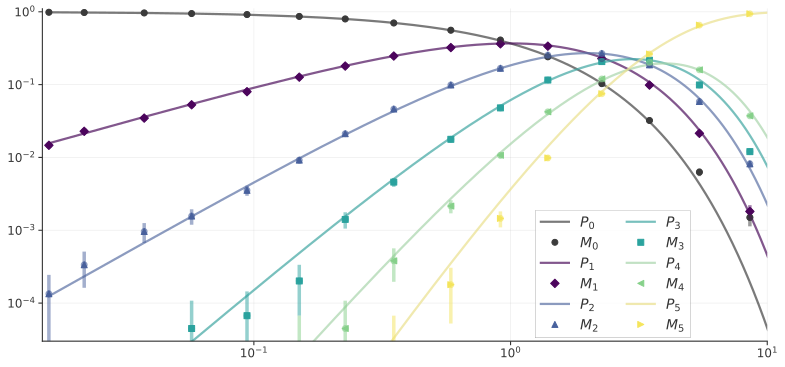

In [84]:
from util import poisson
from util import darken_and_saturate, lighten_and_desaturate
import matplotlib as mpl

# Generate colors
# Create the colormap
num_colors = 5
cmap = plt.cm.viridis
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors.insert(0, "#333333")
hex_colors = [mpl.colors.to_hex(color) for color in colors]
hex_colors = [lighten_and_desaturate(color) for color in hex_colors]
dark_saturated_colors = [darken_and_saturate(color, darken_factor=.9) for color in hex_colors]


min_mfr = mfr_corrected[-1]
max_mfr = mfr_corrected[0]
fine_mfrs = np.linspace(min_mfr, max_mfr, 1000)

# Initialize lists to store the results
lists = [[] for _ in range(6)]
errors_lists = [[] for _ in range(6)]

# Loop over the dB_data objects
for dB_data in dec.list_caller_results:
    dB_data.gmm_optimized_results.filled
    best_guesses = []
    for i, event in enumerate(dB_data.gmm_optimized_results.filled):
        best_guesses.append(event.pnr_best.guess)

    total = len(dB_data.gmm_optimized_results.empty) + len(
        dB_data.gmm_optimized_results.filled
    )
    counts = [
        len(dB_data.gmm_optimized_results.empty),
        np.count_nonzero(np.array(best_guesses) == 1),
        np.count_nonzero(np.array(best_guesses) == 2),
        np.count_nonzero(np.array(best_guesses) == 3),
        np.count_nonzero(np.array(best_guesses) == 4),
        np.count_nonzero(np.array(best_guesses) == 5),
    ]
    errors = [2 * np.sqrt(count) / total for count in counts]

    # Append the results to the corresponding lists
    for i in range(6):
        lists[i].append(counts[i] / total)
        errors_lists[i].append(errors[i])

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
markers = ["o", "D", "^", "s", "<", ">"]
err_args = dict(elinewidth=3.5, capsize=0, alpha=0.5)

# Loop over the different types of data
for i in range(6):
    # Plot the theoretical curve
    ax.plot(
        fine_mfrs,
        [poisson(mfr, i) for mfr in fine_mfrs],
        label=f"$P_{i}$",
        color=hex_colors[i],
        alpha=0.7,
    )
    # Plot the measured data
    ax.plot(
        mfr_corrected,
        lists[i],
        markers[i],
        label=f"$M_{i}$",
        color=dark_saturated_colors[i],
    )
    # Plot the error bars
    ax.errorbar(
        mfr_corrected,
        lists[i],
        yerr=errors_lists[i],
        color=dark_saturated_colors[i],
        fmt="o",
        **err_args,
    )
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(3e-5, 1.1)
ax.set_xlim(1.5e-2, 10)
ax.legend(loc=(0.68, 0.01), ncol=2, fancybox=False, fontsize=14)

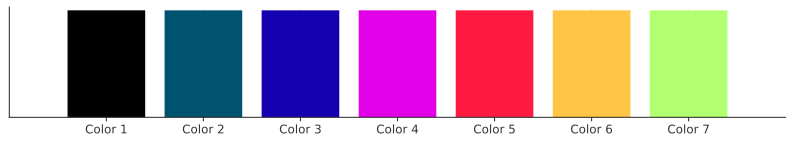

In [85]:
import colorsys
import matplotlib.colors as colors
import matplotlib.pyplot as plt

def mueller_colors(num_colors: int, start_hue: float = -0.4, gamma: float = 1.5, demo_visual = False, max_lightness: float = 1) -> list[str]:
    num_colors += 1
    hex_colors = []
    # Loop over num_colors values
    for i in range(num_colors):
        # Calculate lightness and hue
        lightness = (i / (num_colors - 1)) ** (1 / gamma)  # Apply gamma correction
        lightness *= max_lightness  # Scale to max_lightness
        hue = (i * 360 / (num_colors - 1) / 360 + start_hue) % 1  # Divide by 360 to normalize to [0, 1]
        # Convert HLS to RGB
        rgb = colorsys.hls_to_rgb(hue, lightness, 1)
        # Convert RGB to hex and append to list
        hex_colors.append(colors.rgb2hex(rgb))
    if demo_visual:
        # Create a figure and a subplot
        fig, ax = plt.subplots(1, 1, figsize=(14, 2))
        # Create a bar plot with the colors
        for i, color in enumerate(hex_colors[:-1]):
            ax.bar(i, 1, color=color)

        # Remove y-axis
        ax.get_yaxis().set_visible(False)

        # Set x-axis limits
        ax.set_xlim(-1, num_colors-1)

        # Set x-axis labels
        ax.set_xticks(range(num_colors-1))
        ax.set_xticklabels([f'Color {i+1}' for i in range(num_colors-1)])
    plt.show()
    return hex_colors[:-1]

hex = mueller_colors(7, -0.6, demo_visual=True, max_lightness=0.8)[1:-1]

(10152, 2)


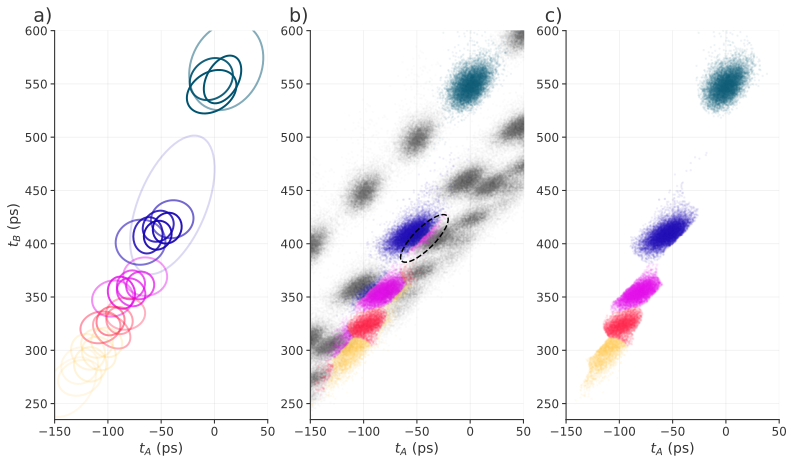

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from util import plot_gmm

# Initialize dictionaries to store locations
locations = {i: [] for i in range(1, 6)}
locations_correct = {i: [] for i in range(1, 6)}

# Define x and y limits
x_min, x_max = -150, 50
y_min, y_max = 235, 600

# Loop over events and append locations to corresponding lists
for event in dec.list_caller_results[5].gmm_optimized_results.filled:
    if 1 <= event.pnr_best.guess <= 5:
        locations[event.pnr_best.guess].append((event.tag_x - 50*event.true, event.tag_y - 50*event.true))
        if event.result == Result.CORRECT:
            locations_correct[event.pnr_best.guess].append((event.tag_x - 50*event.true, event.tag_y - 50*event.true))

# Convert lists to numpy arrays
for i in range(1, 6):
    locations[i] = np.array(locations[i])
    locations_correct[i] = np.array(locations_correct[i])

fig, ax = plt.subplots(1,3, figsize=(13, 9))

print(locations[1].shape)
mask = (locations[1][:, 0] >= x_min) & (locations[1][:, 0] <= x_max) & (locations[1][:, 1] >= y_min) & (locations[1][:, 1] <= y_max)
offset_vector = np.median(locations[1], axis=0)

xy_delay_vector = np.array([0, 548.93812]) # the actual time difference between the low and high trigger levels (found in the waveform directory)

# Loop over locations and plot scatter plots
for i in range(1, 6):
    locations_offset = locations[i] - offset_vector + xy_delay_vector
    mask = (locations_offset[:, 0] >= x_min-1000) & (locations_offset[:, 0] <= x_max+10000) & (locations_offset[:, 1] >= y_min-10000) & (locations_offset[:, 1] <= y_max+10000)
    locations_offset_correct = locations_correct[i] - offset_vector + xy_delay_vector
    mask_correct = (locations_offset_correct[:, 0] >= x_min-10000) & (locations_offset_correct[:, 0] <= x_max+10000) & (locations_offset_correct[:, 1] >= y_min-10000) & (locations_offset_correct[:, 1] <= y_max+10000)

    ax[1].scatter(locations_offset[mask, 0]+3*50, locations_offset[mask, 1]+3*50, label="both methods correct", color='black', s=3, rasterized=True, alpha=0.02)
    ax[1].scatter(locations_offset[mask, 0]+2*50, locations_offset[mask, 1]+2*50, label="both methods correct", color='black', s=3, rasterized=True, alpha=0.02)
    ax[1].scatter(locations_offset[mask, 0]+50, locations_offset[mask, 1]+50, label="both methods correct", color='black', s=3, rasterized=True, alpha=0.02)
    ax[1].scatter(locations_offset[mask, 0]-50, locations_offset[mask, 1]-50, label="both methods correct", color='black', s=3, rasterized=True, alpha=0.02)
    ax[1].scatter(locations_offset[mask, 0]-2*50, locations_offset[mask, 1]-2*50, label="both methods correct", color='black', s=3, rasterized=True, alpha=0.02)
    ax[1].scatter(locations_offset[mask, 0]-3*50, locations_offset[mask, 1]-3*50, label="both methods correct", color='black', s=3, rasterized=True, alpha=0.02)

    ax[1].scatter(locations_offset[mask, 0], locations_offset[mask, 1], label="both methods correct", color=hex[i-1], s=3, rasterized=True, alpha=0.08)
    ax[2].scatter(locations_offset_correct[mask_correct, 0], locations_offset_correct[mask_correct, 1], label="both methods correct", color=hex[i-1], s=3, rasterized=True, alpha=0.08)

# Set limits and aspect ratio for both subplots
for a in ax:
    a.set_xlim(x_min, x_max)
    a.set_ylim(y_min, y_max)
    a.set_aspect('equal')

for i, photon_community in enumerate(sims[5]):
    comm = photon_community.gm_photon

    com_copy = copy.deepcopy(comm)
    com_copy.photon_means = comm.photon_means - offset_vector + xy_delay_vector

    # means_2
    # print(comm.photon_covariances.shape)
    plot_gmm(ax[0], com_copy, color=hex[i], lw=2, single_ellipse=True, weights_as_alpha=True, alpha_scaler=18)

from matplotlib.patches import Ellipse

# ax.add_patch(
#                 Ellipse(
#                     position,
#                     nsig * width,
#                     nsig * height,
#                     angle=angle,
#                     fill=False,
#                     **kwargs
#                 )
#             )



# ax[0].set_title("Photon communities")

ax[0].set_xlabel("$t_A$ (ps)")
ax[0].set_ylabel("$t_B$ (ps)")

ax[1].set_xlabel("$t_A$ (ps)")

ax[2].set_xlabel("$t_A$ (ps)")

# viz.save_light_dark_all(fig, "../figs/pnr_grouppings_test.svg")

ax[0].text(-.1, 1.06, "a)", transform=ax[0].transAxes, fontsize=19, verticalalignment='top')
ax[1].text(-.1, 1.06, "b)", transform=ax[1].transAxes, fontsize=19, verticalalignment='top')
ax[2].text(-.1, 1.06, "c)", transform=ax[2].transAxes, fontsize=19, verticalalignment='top')

ax[1].add_patch(Ellipse((-43,405),20,60,angle=-45,fill=False,ls='--',lw=1.5,color='black'))


you here
you here
you here
you here
you here


(-200.0, 220.0)

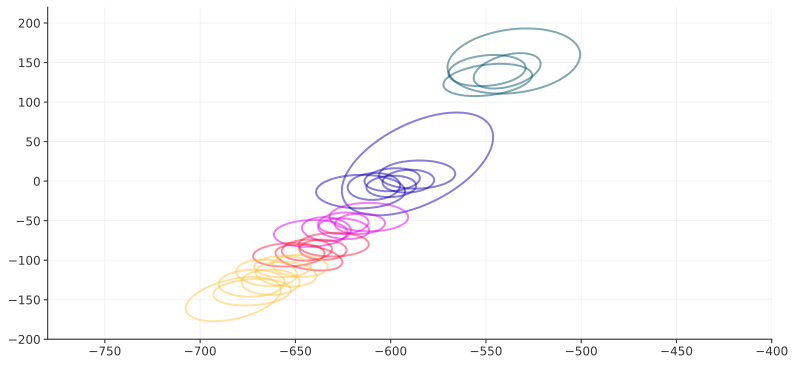

In [20]:
# type(sims[5]
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
     
for i, photon_community in enumerate(sims[5]):
    comm = photon_community.gm_photon
    # print(comm.photon_covariances.shape)
    plot_gmm(ax, comm, color=hex[i], lw=2, single_ellipse=True, alpha=0.5)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)